In [9]:
import pandas as pd
import seaborn as sns
import numpy as np
from PIL import Image
import cv2
import os
import matplotlib.pyplot as plt

In [10]:
color = sns.color_palette()

MODEL_VERSION = "1.0.0"
MODEL_PATH = f"..\\models\\image-matching-challenge-2025-{MODEL_VERSION}.json"
DATASET_PATH = os.path.join("D:", "Datasets", "image-matching-challenge-2025")

In [11]:
train_labels = pd.read_csv(DATASET_PATH + "/train_labels.csv")
train_labels.head()

,dataset,scene,image,rotation_matrix,translation_vector
0,imc2023_haiper,fountain,fountain_image_116.png,0.122655949;0.947713775;-0.294608417;0.1226706...,0.093771314;-0.803560988;2.062001533
1,imc2023_haiper,fountain,fountain_image_108.png,0.474305910;0.359108654;-0.803787832;0.2888416...,0.358946647;-0.797557548;1.910906929
2,imc2023_haiper,fountain,fountain_image_101.png,0.565115476;-0.138485064;-0.813305838;0.506678...,0.146922468;-0.981392596;2.009002852
3,imc2023_haiper,fountain,fountain_image_082.png,-0.308320392;-0.794654112;0.522937261;0.948141...,0.206413831;-1.174321103;3.667167680
4,imc2023_haiper,fountain,fountain_image_071.png,-0.569002830;-0.103808175;0.815757098;0.778745...,-0.015140892;-1.334052012;3.488936597


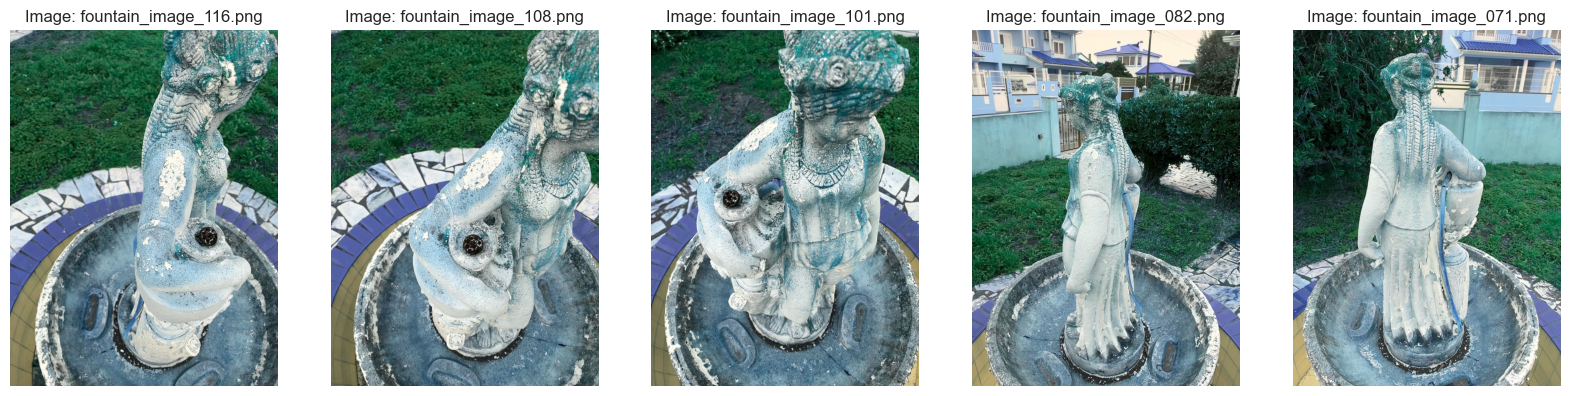

In [12]:
scene_name = "fountain"
scene_images = train_labels[train_labels["scene"] == scene_name]["image"].values[:5]

fig, axes = plt.subplots(1, 5, figsize=(20, 10))

img_paths = []

for i, img_name in enumerate(scene_images):
    img_path = os.path.join(DATASET_PATH, "train",
                            train_labels[train_labels["scene"] == scene_name]["dataset"].values[0],
                            img_name)

    img_paths.append(img_path)

    img = cv2.imread(img_path)

    axes[i].imshow(img)
    axes[i].set_title(f"Image: {img_name}")
    axes[i].axis("off")

plt.show()


In [13]:
img_paths

['D:Datasets\\image-matching-challenge-2025\\train\\imc2023_haiper\\fountain_image_116.png',
 'D:Datasets\\image-matching-challenge-2025\\train\\imc2023_haiper\\fountain_image_108.png',
 'D:Datasets\\image-matching-challenge-2025\\train\\imc2023_haiper\\fountain_image_101.png',
 'D:Datasets\\image-matching-challenge-2025\\train\\imc2023_haiper\\fountain_image_082.png',
 'D:Datasets\\image-matching-challenge-2025\\train\\imc2023_haiper\\fountain_image_071.png']

In [14]:
train_labels["scene"].nunique()

30

In [15]:
# Reinitialize Q0 for fresh computation
Q0 = np.array([
    [np.inf, np.inf, np.inf, 3],
    [2,      np.inf, 8,      9],
    [9,      5,      np.inf, np.inf],
    [6,      np.inf, 2,      np.inf]
])

# Number of nodes
n = Q0.shape[0]

# Store Q0 and initialize the list of stages
Q_stages = [Q0.copy()]

# Apply Floyd-Warshall step-by-step
for k in range(n):
    Q_prev = Q_stages[-1]
    Q_next = Q_prev.copy()
    for i in range(n):
        for j in range(n):
            if Q_prev[i][k] + Q_prev[k][j] < Q_prev[i][j]:
                Q_next[i][j] = Q_prev[i][k] + Q_prev[k][j]
    Q_stages.append(Q_next)

# Format all stages as dictionaries for easier display
Q_named = {
    f"Q{k}": Q_stages[k] for k in range(1, 5)
}

Q_named


{'Q1': array([[inf, inf, inf,  3.],
        [ 2., inf,  8.,  5.],
        [ 9.,  5., inf, 12.],
        [ 6., inf,  2.,  9.]]),
 'Q2': array([[inf, inf, inf,  3.],
        [ 2., inf,  8.,  5.],
        [ 7.,  5., 13., 10.],
        [ 6., inf,  2.,  9.]]),
 'Q3': array([[inf, inf, inf,  3.],
        [ 2., 13.,  8.,  5.],
        [ 7.,  5., 13., 10.],
        [ 6.,  7.,  2.,  9.]]),
 'Q4': array([[ 9., 10.,  5.,  3.],
        [ 2., 12.,  7.,  5.],
        [ 7.,  5., 12., 10.],
        [ 6.,  7.,  2.,  9.]])}

In [16]:
# Define the initial path matrix P0 (0s and 1s)
P0 = np.array([
    [0, 0, 0, 1],
    [1, 0, 1, 1],
    [1, 1, 0, 0],
    [1, 0, 1, 0]
], dtype=int)

# Number of nodes
n = P0.shape[0]

# Store the stages
P_stages = [P0.copy()]

# Apply Warshall's algorithm to compute the transitive closure
for k in range(n):
    P_prev = P_stages[-1]
    P_next = P_prev.copy()
    for i in range(n):
        for j in range(n):
            if P_prev[i][j] or (P_prev[i][k] and P_prev[k][j]):
                P_next[i][j] = 1
    P_stages.append(P_next)

# Prepare the results to display P0 to P4
P_named = {f"P{k}": P_stages[k] for k in range(5)}
P_named

{'P0': array([[0, 0, 0, 1],
        [1, 0, 1, 1],
        [1, 1, 0, 0],
        [1, 0, 1, 0]]),
 'P1': array([[0, 0, 0, 1],
        [1, 0, 1, 1],
        [1, 1, 0, 1],
        [1, 0, 1, 1]]),
 'P2': array([[0, 0, 0, 1],
        [1, 0, 1, 1],
        [1, 1, 1, 1],
        [1, 0, 1, 1]]),
 'P3': array([[0, 0, 0, 1],
        [1, 1, 1, 1],
        [1, 1, 1, 1],
        [1, 1, 1, 1]]),
 'P4': array([[1, 1, 1, 1],
        [1, 1, 1, 1],
        [1, 1, 1, 1],
        [1, 1, 1, 1]])}